# MSE 215 - "Big data in materials science"

[Donny Winston](mailto:dwinston@lbl.gov), [Joseph Montoya](mailto:montoyjh@lbl.gov)

In this notebook, we cover some basic examples of how to use the Materials Project API (MAPI) to analyze information on structure and phase.  In the next lesson, we will cover more advanced examples.

Setup: to execute the cells in this notebook, you should have installed the [Anaconda](anaconda.org) distribution of python.  You also must set your API key using the command `pmg config --add MAPI_KEY YOUR_API_KEY_HERE` using your api key from the MP dashboard at [materialsproject.org](materialsproject.org).

### A few jupyter notebook and python basics

Note that the jupyter/python material we've included here is **very** minimal, but python is a full object-oriented programming language with an extended ecosystem for scientific computing.  You can find more information about python in the [documentation](https://docs.python.org/3/), and [this gallery of interesting ipython notebooks](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks) is one of my favorite resources with examples from scientific computing.  Some popular python packages that are not included in the standard library are numpy, scipy, matplotlib (for plotting), pandas, scikit-learn, and pymatgen.

In [1]:
# Press shift+Enter to execute cells
print("Hello world!")

Hello world!


In [2]:
# Stored variables persist throughout the entire notebook, not just within cells
this_number = 5

In [3]:
print(this_number)

5


In [4]:
# Modules, submodules, and functions are accessed via import statements and "dot notation"
import numpy

# Get an array of 5 random values (from zero to 1)
numpy.random.random(5)

array([ 0.60573069,  0.10609853,  0.54822765,  0.87217581,  0.96670286])

In [5]:
# You can access help on a function by pressing shift enter 
# within the parentheses following the function or by using help(function)
numpy.random.random()

0.0785380116797616

In [6]:
# Autocompletion of submodules, functions, and even files/directories can be achieved using tab.
# Try typing an incomplete function name to see your options.
numpy.random.poisson()

1

## Pymatgen and The Materials Project Rester

We'll start with a simple example of constructing a phase diagram from data retrieving using the Materials Project REST interface, which can be accessed using code in the pymatgen python package.

In [7]:
# Import necessary modules
from pymatgen import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from pymatgen.entries.computed_entries import ComputedEntry

In [8]:
# instantiate MP Rester
mpr = MPRester()

In [9]:
# Get a list of "entries"
entries_li_o = mpr.get_entries_in_chemsys(["Li", "O"])

In [10]:
# Access individual elements of a list using bracket notation
entries_li_o[20]

# Access attributes of individual elements of a list using dot notation
one_entry = entries_li_o[20]
print("Energy is", one_entry.energy)
print("Correction is", one_entry.correction)

Energy is -157.70191129
Correction is -7.45952


In [11]:
pd = PhaseDiagram(entries_li_o)

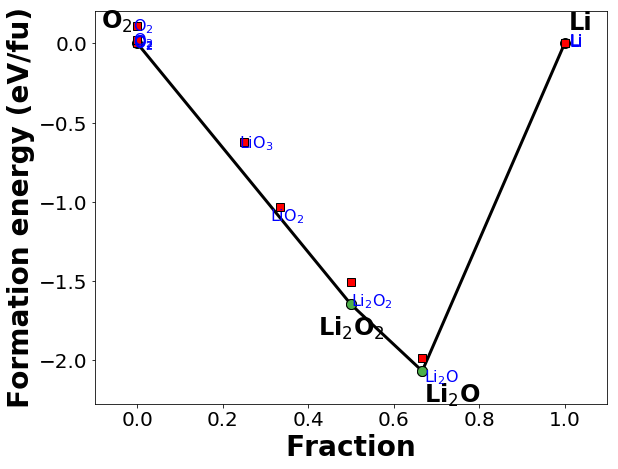

In [12]:
plotter = PDPlotter(pd, show_unstable=True)
plotter.show()

### Exercise: [Lithium-Sulfur batteries](http://pubs.acs.org/doi/abs/10.1021/cr500062v) are currently being heavily researched for applications in energy storage.  Plot the phase diagram for Li-S.

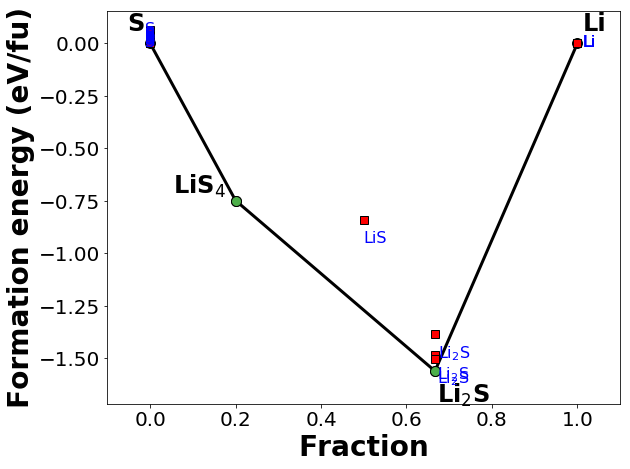

In [13]:
entries_li_s = mpr.get_entries_in_chemsys(["Li", "S"])
pd = PhaseDiagram(entries_li_s)
plotter = PDPlotter(pd, show_unstable=True)
plotter.show()

In [14]:
# Get energy above hull for a certain entry
pd.get_e_above_hull(entries_li_s[29])

0.42903351535714229

In [15]:
# Find decomposition products
pd.get_decomp_and_e_above_hull(entries_li_s[29])

({ComputedEntry Li2 S8
  Energy = -39.0145
  Correction = -5.3077
  Parameters:
  is_hubbard = False
  hubbards = {}
  potcar_symbols = ['pbe Li_sv', 'pbe S']
  run_type = GGA
  pseudo_potential = {'functional': 'pbe', 'labels': ['Li_sv', 'S'], 'pot_type': 'paw'}
  oxide_type = None
  Data:
  oxide_type = None: 0.35714285714285698, ComputedEntry Li2 S1
  Energy = -11.9626
  Correction = -0.6635
  Parameters:
  is_hubbard = False
  hubbards = {}
  potcar_symbols = ['pbe Li_sv', 'pbe S']
  run_type = GGA
  pseudo_potential = {'functional': 'pbe', 'labels': ['Li_sv', 'S'], 'pot_type': 'paw'}
  oxide_type = None
  Data:
  oxide_type = None: 0.64285714285714302}, 0.42903351535714229)

### Independent exercise: The pymatgen Phase Diagram infrastructure began as much of the code used to write [this paper](http://pubs.acs.org/doi/full/10.1021/cm702327g) on Li-Fe-P-O phase behavior.  Construct and inspect ternary phase diagrams for combinations of 3 of the elements taken from each chemical system. 

## Advanced querying and structure matching

Querying the database uses syntax very similar to that used in [MongoDB](https://docs.mongodb.com/manual/tutorial/query-documents/).  You can find information about what information can be used as criteria or returned in properties in the [MAPI Documentation](https://github.com/materialsproject/mapidoc).

In [16]:
# Querying uses document criteria and property lists
data = mpr.query(criteria={"pretty_formula": "SiO2"},
                 properties=['material_id', 'band_gap'])

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

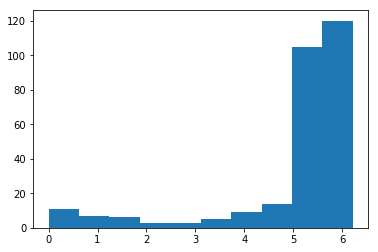

In [18]:
band_gaps = [d["band_gap"] for d in data]
plt.hist(band_gaps)
plt.show()

In [19]:
wide_bg_data = mpr.query({"band_gap": {"$gt": 7}}, ["band_gap", "pretty_formula", "e_above_hull"])

In [20]:
len(wide_bg_data)

175

In [21]:
band_gaps = [d['band_gap'] for d in wide_bg_data]
hull_es = [d['e_above_hull'] for d in wide_bg_data]

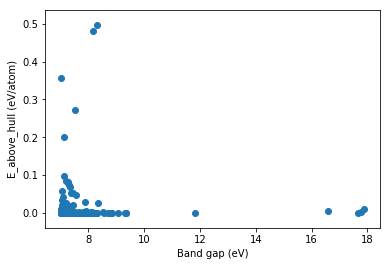

In [22]:
plt.scatter(band_gaps, hull_es)
plt.xlabel("Band gap (eV)")
plt.ylabel("E_above_hull (eV/atom)")

## You're looking for a new material for a transparent screen protector.  It must have a band gap greater than 4, a shear modulus greater than 100 GPa, and be stable (e above hull less than 0.05 eV)

In [23]:
screen_mats = mpr.query({"elasticity.G_VRH": {"$gt": 100}, "e_above_hull": {"$lt": 0.05}, "band_gap": {"$gt": 4}},
                        properties=["material_id", "elasticity.G_VRH", "e_above_hull", "band_gap", "pretty_formula"])

In [24]:
formulas = [d['pretty_formula'] for d in screen_mats]
g_vrhs = [d["elasticity.G_VRH"] for d in screen_mats]
bgs = [d['band_gap'] for d in screen_mats]

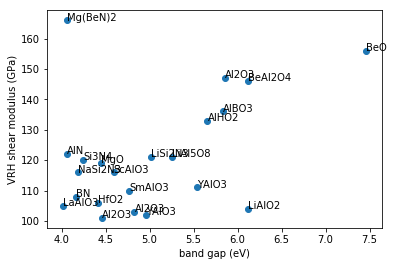

In [25]:
plt.scatter(bgs, g_vrhs)
for bg, g_vrh, formula in zip(bgs, g_vrhs, formulas):
    plt.annotate(formula, (bg, g_vrh))
plt.xlabel("band gap (eV)")
plt.ylabel("VRH shear modulus (GPa)")
plt.show()

## Structure matching

The pymatgen structure object is used extensively throughout the MP stack to determine structural characteristics and the Structure Matcher is a key component which determines whether two distinct settings of a given structure are equivalent.  The basic algorithm for this reduces both structures to a standard primitive setting using the Spacegroup Analyzer and comparing the fractional positions of given atoms and lattices to determine whether they are within the provided tolerances.

In [26]:
from pymatgen import Structure, Lattice
from pymatgen.analysis.structure_matcher import StructureMatcher

In [27]:
bcc_mo = Structure(Lattice.cubic(3.14), ["Mo", "Mo"], [[0, 0, 0], [0.5, 0.5, 0.5]])

In [28]:
primitive_mo = bcc_mo.get_primitive_structure()

In [29]:
sm = StructureMatcher()
print(sm.fit(bcc_mo, primitive_mo))

True


In [30]:
bcc_w = Structure(Lattice.cubic(3.16), ["W", "W"], [[0, 0, 0], [0.5, 0.5, 0.5]])

In [31]:
print(sm.fit(bcc_mo, bcc_w))

None


In [32]:
sm.fit_anonymous(primitive_mo, bcc_w)

True

In [33]:
# You can find structures on mp using these methods behind the scenes:
mpr.find_structure(bcc_mo)

['mp-129']

## Exercise - Finding a new piezoelectric material using a template

A collaborator is interested in testing high piezoelectric moduli materials. You look at the materials project and find that the highest piezo response corresponds to Pr<sub>3</sub>NF<sub>6</sub> (mp-33319). Use the structure matcher to find similar structures with the same anonymous formula.

In [34]:
# Finding that structure
piezo_data = mpr.query({"piezo.eij_max": {"$gt": 10}}, ['structure', 'material_id', "piezo.eij_max"])

In [35]:
piezo_data = sorted(piezo_data, key=lambda x: -x["piezo.eij_max"])

In [36]:
template_structure = piezo_data[0]["structure"]

In [37]:
template_structure.composition.anonymized_formula

'AB3C6'

In [38]:
data = mpr.query({"anonymous_formula": {"A": 1, "B": 3, "C": 6}, "e_above_hull": {"$lt": 0.2}}, 
                 ["material_id", "structure"])

In [39]:
len(data)

329

In [40]:
sm = StructureMatcher()
matches = []
for d in data:
    if sm.fit_anonymous(template_structure, d['structure']):
        print(d['material_id'], 'matches the template structure')
        matches.append(d)

mp-33319 matches the template structure
mp-675921 matches the template structure


In [41]:
matches

[{'material_id': 'mp-33319', 'structure': Structure Summary
  Lattice
      abc : 4.026778981974493 12.417926991663338 7.1926623769603681
   angles : 30.403077902974239 56.28747789136947 62.456318406653992
   volume : 151.29583701509338
        A : 4.0259510799999996 -0.05522175 0.060145070000000002
        B : 5.8916869800000002 10.930633179999999 0.11913683
        C : 4.0073707299999999 4.8496714000000001 3.48655406
  PeriodicSite: F (3.9076, 4.9343, 0.8231) [0.2321, 0.3550, 0.2200]
  PeriodicSite: F (6.1284, 7.1389, 1.3942) [0.4332, 0.4886, 0.3757]
  PeriodicSite: F (7.9973, 7.1012, 3.2256) [0.7175, 0.2521, 0.9042]
  PeriodicSite: F (7.9065, 12.0721, 1.0092) [0.2588, 0.9944, 0.2510]
  PeriodicSite: F (8.7378, 9.1319, 1.6647) [0.7890, 0.6434, 0.4419]
  PeriodicSite: F (10.0465, 11.1023, 2.5448) [0.7638, 0.7124, 0.6924]
  PeriodicSite: N (5.8060, 3.4718, 2.5620) [0.7220, 0.0008, 0.7223]
  PeriodicSite: Pr (7.8690, 4.6145, 3.4137) [0.9965, 0.0004, 0.9619]
  PeriodicSite: Pr (5.9656, 3

You can see an example of using structural motifs identified by the structure matcher in existing data in one of your classmate's [recent papers on auxetic materials](https://www.nature.com/articles/s41467-017-00399-6).